In [2]:
import os
import cv2
import json
import torch
import numpy as np

from PIL import Image
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
# !pip install torch torchvision pandas scikit-learn

In [3]:
def collect_image_age_pairs(image_root_dir, json_root_dir):
    pairs = []
    
    # subject_id dir 반복
    subject_ids = sorted([d for d in os.listdir(image_root_dir) if os.path.isdir(os.path.join(image_root_dir, d))])
    
    print(f"총 subject 수: {len(subject_ids)}")
    
    for subject_id in subject_ids:
        subject_image_dir = os.path.join(image_root_dir, subject_id)
        subject_json_dir = os.path.join(json_root_dir, subject_id)
        if not os.path.exists(subject_json_dir):
            print(f"[경고] JSON 디렉토리 없음: {subject_json_dir}")
            continue
        
        #이미지 파일 중 Jpg만 추출
        jpg_files = [f for f in os.listdir(subject_image_dir) if f.endswith('.jpg')]
        
        for jpg_file in jpg_files:
            base_name = jpg_file.replace('.jpg', '')
            json_filename = f"{base_name}_00.json"
            json_path = os.path.join(subject_json_dir, json_filename)
            jpg_path = os.path.join(subject_image_dir, jpg_file)
            
            if os.path.exists(json_path):
                try:
                    with open(json_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        age = data['info']['age'] #info[4]
                        pairs.append((jpg_path, age))
                        
                except Exception as e:
                    print(f"[오류] JSON 파싱 실패: {json_path} - {e}")
            else:
                print(f"[경고] JSON 파일 없음: {json_path}")
                
    return pairs

In [4]:
#루트 경로 
image_root = '/home/alpaco/yskim/data/Training/origin/digitalCamera'
json_root = '/home/alpaco/yskim/data/Training/lable/digitalCamera'

# 실행
image_age_pairs = collect_image_age_pairs(image_root, json_root)

# 결과
print(f"총 매칭 이미지 수: {len(image_age_pairs)}")
print("샘플 10:")
for i in range(min(10, len(image_age_pairs))):
    print(image_age_pairs[i])

총 subject 수: 858
총 매칭 이미지 수: 6006
샘플 10:
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_L15.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_Fb.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_L30.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_Ft.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_F.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_R15.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0002/0002_01_R30.jpg', 50)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_Fb.jpg', 24)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_F.jpg', 24)
('/home/alpaco/yskim/data/Training/origin/digitalCamera/0003/0003_01_L15.jpg', 24)


In [5]:
import pandas as pd

df = pd.DataFrame(image_age_pairs, columns=['image_path', 'age'])
print(df.head())

                                          image_path  age
0  /home/alpaco/yskim/data/Training/origin/digita...   50
1  /home/alpaco/yskim/data/Training/origin/digita...   50
2  /home/alpaco/yskim/data/Training/origin/digita...   50
3  /home/alpaco/yskim/data/Training/origin/digita...   50
4  /home/alpaco/yskim/data/Training/origin/digita...   50


### ResNet 학습
1. data준비
2. custom dataset 클래스 정의
3. 이미지 전처리
    - Horizontal equalize
4. 모델 구성(ResNet)
5. Regression Loss (MSELoss)
6. 학습루프 작성(Train/val)
7. 성능평가(MAE, RMSE)

In [6]:
!pip install torch torchvision pandas scikit-learn timm pandas

In [7]:
df = pd.DataFrame(image_age_pairs, columns=['image_path', 'age'])

In [8]:
# Dataset 정의 
class AgeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        age = self.df.iloc[idx]['age']
        image = Image.open(img_path).convert("RGB")
    
        if self.transform:
            image = self.transform(image)
    
        return image, torch.tensor(age, dtype=torch.float32)

In [9]:
!pip install scikit-image

In [10]:
!pip install --upgrade gdown

  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.3
    Uninstalling gdown-4.6.3:
      Successfully uninstalled gdown-4.6.3


In [11]:
!pip install gdown==v4.6.3

  Using cached gdown-4.6.3-py3-none-any.whl.metadata (4.4 kB)
Using cached gdown-4.6.3-py3-none-any.whl (14 kB)
  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [12]:
from skimage import io, exposure, img_as_ubyte
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from PIL import Image
import torch
import os
from torchvision import transforms

%matplotlib inline

In [13]:
# Horizontal Equalizing
image_root = '/home/alpaco/yskim/data/Training/origin/digitalCamera'
output_folder = '/home/alpaco/yskim/data/Training/CLAHE/digitalCamera'
os.makedirs(output_folder, exist_ok=True)

image_files = [f for f in os.listdir(image_root) if f.lower().endswith('.jpg')]

for file in image_files:
    image_path = os.path.join(image_root, file)
    image = io.imread(image_path)

    if image.ndim == 3:
        image_gray = rgb2gray(image)
    else:
        image_gray = image

    equalized = exposure.equalize_adapthist(image_gray, clip_limit=0.03)
    output_path = os.path.join(output_folder, f'equalized_{file}')
    io.imsave(output_path, img_as_ubyte(equalized))
    print(f"Saved: {output_path}")

In [14]:
# Custom Data

class AgeRegressionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        age = self.df.iloc[idx]['age']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(age, dtype=torch.float32)

In [15]:
# transform 정의 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)])

In [16]:
#데이터 분할
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch
import torch.nn.functional as F
from torch import optim
from PIL import ImageFile
from tqdm import tqdm
from skimage import io, exposure, img_as_ubyte
from skimage.color import rgb2gray

df = pd.DataFrame(image_age_pairs, columns=['image_path', 'age'])
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = AgeRegressionDataset(train_df, transform=transform)
val_dataset = AgeRegressionDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [17]:
#ResNet regression 학습
class AgeRegressor(nn.Module):
    def __init__(self):
        super(AgeRegressor, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1) 
    
    def forward(self, x):
        return self.backbone(x).squeeze(1)

In [18]:
#학습 루프
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgeRegressor().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

/home/alpaco/anaconda3/envs/alpacosry/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alpaco/anaconda3/envs/alpacosry/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 결과 저장 리스트 ---
train_loss_history = []
train_mae_history = []
train_rmse_history = []

val_loss_history = []
val_mae_history = []
val_rmse_history = []

for epoch in range(30):
    # ----- Train -----
    model.train()
    train_loss = 0
    all_preds = []
    all_labels = []

    for images, ages in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training"):
        images, ages = images.to(device), ages.to(device)

        preds = model(images).squeeze()
        loss = criterion(preds, ages.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(ages.detach().cpu().numpy())

    avg_loss = train_loss / len(train_loader.dataset)
    mae = mean_absolute_error(all_labels, all_preds)
    rmse = mean_squared_error(all_labels, all_preds, squared=False)

    train_loss_history.append(avg_loss)
    train_mae_history.append(mae)
    train_rmse_history.append(rmse)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    # ----- Validation -----
    model.eval()
    total_loss = 0.0
    true_ages, pred_ages = [], []

    with torch.no_grad():
        for images, ages in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation"):
            images = images.to(device)
            ages = ages.to(device)

            preds = model(images).squeeze()
            loss = criterion(preds, ages.float())

            total_loss += loss.item() * images.size(0)
            true_ages.extend(ages.detach().cpu().numpy())
            pred_ages.extend(preds.detach().cpu().numpy())

    val_avg_loss = total_loss / len(val_loader.dataset)
    v_mae = mean_absolute_error(true_ages, pred_ages)
    v_rmse = mean_squared_error(true_ages, pred_ages, squared=False)

    val_loss_history.append(val_avg_loss)
    val_mae_history.append(v_mae)
    val_rmse_history.append(v_rmse)

    print(f"[Epoch {epoch+1}] Val Loss: {val_avg_loss:.4f} | MAE: {v_mae:.4f} | RMSE: {v_rmse:.4f}")

[Epoch 1] Training: 100%|██████████| 151/151 [42:02<00:00, 16.71s/it]


[Epoch 1] Train Loss: 915.4249 | MAE: 28.3702 | RMSE: 30.2560


[Epoch 1] Validation: 100%|██████████| 38/38 [04:42<00:00,  7.44s/it]


[Epoch 1] Val Loss: 992.9671 | MAE: 30.7242 | RMSE: 31.5114


[Epoch 2] Training: 100%|██████████| 151/151 [29:54<00:00, 11.88s/it]


[Epoch 2] Train Loss: 177.4445 | MAE: 11.8224 | RMSE: 13.3208


[Epoch 2] Validation: 100%|██████████| 38/38 [02:50<00:00,  4.49s/it]


[Epoch 2] Val Loss: 38.0761 | MAE: 4.7580 | RMSE: 6.1706


[Epoch 3] Training: 100%|██████████| 151/151 [20:45<00:00,  8.25s/it]


[Epoch 3] Train Loss: 31.5330 | MAE: 4.4682 | RMSE: 5.6154


[Epoch 3] Validation: 100%|██████████| 38/38 [02:40<00:00,  4.22s/it]


[Epoch 3] Val Loss: 16.1464 | MAE: 2.9815 | RMSE: 4.0183


[Epoch 4] Training: 100%|██████████| 151/151 [20:46<00:00,  8.25s/it]


[Epoch 4] Train Loss: 16.2491 | MAE: 3.1506 | RMSE: 4.0310


[Epoch 4] Validation: 100%|██████████| 38/38 [02:48<00:00,  4.44s/it]


[Epoch 4] Val Loss: 14.7106 | MAE: 2.9617 | RMSE: 3.8354


[Epoch 5] Training: 100%|██████████| 151/151 [20:02<00:00,  7.96s/it]


[Epoch 5] Train Loss: 11.3180 | MAE: 2.6464 | RMSE: 3.3642


[Epoch 5] Validation: 100%|██████████| 38/38 [02:43<00:00,  4.30s/it]


[Epoch 5] Val Loss: 10.4332 | MAE: 2.4465 | RMSE: 3.2301


[Epoch 6] Training: 100%|██████████| 151/151 [20:14<00:00,  8.04s/it]


[Epoch 6] Train Loss: 11.7382 | MAE: 2.6857 | RMSE: 3.4261


[Epoch 6] Validation: 100%|██████████| 38/38 [02:46<00:00,  4.37s/it]


[Epoch 6] Val Loss: 11.5874 | MAE: 2.5927 | RMSE: 3.4040


[Epoch 7] Training: 100%|██████████| 151/151 [19:54<00:00,  7.91s/it]


[Epoch 7] Train Loss: 12.1267 | MAE: 2.7438 | RMSE: 3.4823


[Epoch 7] Validation: 100%|██████████| 38/38 [02:43<00:00,  4.29s/it]


[Epoch 7] Val Loss: 10.6980 | MAE: 2.5575 | RMSE: 3.2708


[Epoch 8] Training: 100%|██████████| 151/151 [20:51<00:00,  8.29s/it]


[Epoch 8] Train Loss: 9.0955 | MAE: 2.3576 | RMSE: 3.0159


[Epoch 8] Validation: 100%|██████████| 38/38 [02:38<00:00,  4.18s/it]


[Epoch 8] Val Loss: 13.8750 | MAE: 2.9635 | RMSE: 3.7249


[Epoch 9] Training: 100%|██████████| 151/151 [20:01<00:00,  7.96s/it]


[Epoch 9] Train Loss: 10.3956 | MAE: 2.5099 | RMSE: 3.2242


[Epoch 9] Validation: 100%|██████████| 38/38 [02:37<00:00,  4.14s/it]


[Epoch 9] Val Loss: 16.1105 | MAE: 3.1677 | RMSE: 4.0138


[Epoch 10] Training: 100%|██████████| 151/151 [20:18<00:00,  8.07s/it]


[Epoch 10] Train Loss: 9.2542 | MAE: 2.4058 | RMSE: 3.0421


[Epoch 10] Validation: 100%|██████████| 38/38 [02:53<00:00,  4.56s/it]


[Epoch 10] Val Loss: 33.9378 | MAE: 4.8712 | RMSE: 5.8256


[Epoch 11] Training: 100%|██████████| 151/151 [20:34<00:00,  8.18s/it]


[Epoch 11] Train Loss: 10.4357 | MAE: 2.5352 | RMSE: 3.2304


[Epoch 11] Validation: 100%|██████████| 38/38 [02:47<00:00,  4.42s/it]


[Epoch 11] Val Loss: 16.8852 | MAE: 3.2618 | RMSE: 4.1092


[Epoch 12] Training: 100%|██████████| 151/151 [20:04<00:00,  7.98s/it]


[Epoch 12] Train Loss: 6.5840 | MAE: 2.0009 | RMSE: 2.5659


[Epoch 12] Validation: 100%|██████████| 38/38 [02:38<00:00,  4.18s/it]


[Epoch 12] Val Loss: 12.1011 | MAE: 2.7260 | RMSE: 3.4787


[Epoch 13] Training: 100%|██████████| 151/151 [20:09<00:00,  8.01s/it]


[Epoch 13] Train Loss: 5.2913 | MAE: 1.7961 | RMSE: 2.3003


[Epoch 13] Validation: 100%|██████████| 38/38 [02:46<00:00,  4.39s/it]


[Epoch 13] Val Loss: 9.3491 | MAE: 2.3535 | RMSE: 3.0576


[Epoch 14] Training: 100%|██████████| 151/151 [20:35<00:00,  8.18s/it]


[Epoch 14] Train Loss: 4.7383 | MAE: 1.6936 | RMSE: 2.1768


[Epoch 14] Validation: 100%|██████████| 38/38 [02:39<00:00,  4.21s/it]


[Epoch 14] Val Loss: 28.8025 | MAE: 4.5858 | RMSE: 5.3668


[Epoch 15] Training: 100%|██████████| 151/151 [20:07<00:00,  8.00s/it]


[Epoch 15] Train Loss: 6.3612 | MAE: 1.9354 | RMSE: 2.5221


[Epoch 15] Validation: 100%|██████████| 38/38 [02:49<00:00,  4.46s/it]


[Epoch 15] Val Loss: 11.0422 | MAE: 2.5983 | RMSE: 3.3230


[Epoch 16] Training: 100%|██████████| 151/151 [20:13<00:00,  8.03s/it]


[Epoch 16] Train Loss: 4.3425 | MAE: 1.6323 | RMSE: 2.0839


[Epoch 16] Validation: 100%|██████████| 38/38 [02:41<00:00,  4.26s/it]


[Epoch 16] Val Loss: 15.2104 | MAE: 3.0865 | RMSE: 3.9001


[Epoch 17] Training: 100%|██████████| 151/151 [20:16<00:00,  8.05s/it]


[Epoch 17] Train Loss: 4.7295 | MAE: 1.7210 | RMSE: 2.1747


[Epoch 17] Validation: 100%|██████████| 38/38 [02:54<00:00,  4.59s/it]


[Epoch 17] Val Loss: 9.6324 | MAE: 2.3594 | RMSE: 3.1036


[Epoch 18] Training: 100%|██████████| 151/151 [20:25<00:00,  8.11s/it]


[Epoch 18] Train Loss: 4.8821 | MAE: 1.7159 | RMSE: 2.2096


[Epoch 18] Validation: 100%|██████████| 38/38 [02:36<00:00,  4.13s/it]


[Epoch 18] Val Loss: 9.6398 | MAE: 2.3393 | RMSE: 3.1048


[Epoch 19] Training: 100%|██████████| 151/151 [20:00<00:00,  7.95s/it]


[Epoch 19] Train Loss: 2.2712 | MAE: 1.1631 | RMSE: 1.5070


[Epoch 19] Validation: 100%|██████████| 38/38 [02:43<00:00,  4.31s/it]


[Epoch 19] Val Loss: 12.4629 | MAE: 2.7519 | RMSE: 3.5303


[Epoch 20] Training: 100%|██████████| 151/151 [20:08<00:00,  8.01s/it]


[Epoch 20] Train Loss: 6.5658 | MAE: 2.0046 | RMSE: 2.5624


[Epoch 20] Validation: 100%|██████████| 38/38 [02:38<00:00,  4.16s/it]


[Epoch 20] Val Loss: 10.8666 | MAE: 2.4556 | RMSE: 3.2965


[Epoch 21] Training: 100%|██████████| 151/151 [19:46<00:00,  7.86s/it]


[Epoch 21] Train Loss: 8.4735 | MAE: 2.2098 | RMSE: 2.9109


[Epoch 21] Validation: 100%|██████████| 38/38 [02:45<00:00,  4.35s/it]


[Epoch 21] Val Loss: 10.3740 | MAE: 2.4140 | RMSE: 3.2209


[Epoch 22] Training: 100%|██████████| 151/151 [20:10<00:00,  8.02s/it]


[Epoch 22] Train Loss: 3.2162 | MAE: 1.4226 | RMSE: 1.7934


[Epoch 22] Validation: 100%|██████████| 38/38 [02:59<00:00,  4.73s/it]


[Epoch 22] Val Loss: 11.6694 | MAE: 2.6322 | RMSE: 3.4161


[Epoch 23] Training: 100%|██████████| 151/151 [20:14<00:00,  8.04s/it]


[Epoch 23] Train Loss: 2.4695 | MAE: 1.2114 | RMSE: 1.5714


[Epoch 23] Validation: 100%|██████████| 38/38 [02:37<00:00,  4.13s/it]


[Epoch 23] Val Loss: 12.0969 | MAE: 2.7022 | RMSE: 3.4781


[Epoch 24] Training: 100%|██████████| 151/151 [20:08<00:00,  8.00s/it]


[Epoch 24] Train Loss: 2.0271 | MAE: 1.1048 | RMSE: 1.4237


[Epoch 24] Validation: 100%|██████████| 38/38 [02:53<00:00,  4.56s/it]


[Epoch 24] Val Loss: 9.3968 | MAE: 2.3106 | RMSE: 3.0654


[Epoch 25] Training: 100%|██████████| 151/151 [20:01<00:00,  7.96s/it]


[Epoch 25] Train Loss: 1.7830 | MAE: 1.0459 | RMSE: 1.3353


[Epoch 25] Validation: 100%|██████████| 38/38 [02:38<00:00,  4.18s/it]


[Epoch 25] Val Loss: 9.2405 | MAE: 2.1870 | RMSE: 3.0398


[Epoch 26] Training: 100%|██████████| 151/151 [20:26<00:00,  8.13s/it]


[Epoch 26] Train Loss: 2.7518 | MAE: 1.2208 | RMSE: 1.6588


[Epoch 26] Validation: 100%|██████████| 38/38 [02:57<00:00,  4.66s/it]


[Epoch 26] Val Loss: 12.0242 | MAE: 2.6585 | RMSE: 3.4676


[Epoch 27] Training: 100%|██████████| 151/151 [20:29<00:00,  8.14s/it]


[Epoch 27] Train Loss: 13.7547 | MAE: 2.9019 | RMSE: 3.7087


[Epoch 27] Validation: 100%|██████████| 38/38 [02:59<00:00,  4.71s/it]


[Epoch 27] Val Loss: 10.5855 | MAE: 2.4709 | RMSE: 3.2535


[Epoch 28] Training: 100%|██████████| 151/151 [20:04<00:00,  7.98s/it]


[Epoch 28] Train Loss: 4.3963 | MAE: 1.6187 | RMSE: 2.0967


[Epoch 28] Validation: 100%|██████████| 38/38 [02:53<00:00,  4.57s/it]


[Epoch 28] Val Loss: 12.3927 | MAE: 2.7522 | RMSE: 3.5203


[Epoch 29] Training: 100%|██████████| 151/151 [19:08<00:00,  7.61s/it]


[Epoch 29] Train Loss: 3.5093 | MAE: 1.4182 | RMSE: 1.8733


[Epoch 29] Validation: 100%|██████████| 38/38 [02:34<00:00,  4.07s/it]


[Epoch 29] Val Loss: 8.9872 | MAE: 2.2271 | RMSE: 2.9979


[Epoch 30] Training: 100%|██████████| 151/151 [19:43<00:00,  7.84s/it]


[Epoch 30] Train Loss: 2.8470 | MAE: 1.3051 | RMSE: 1.6873


[Epoch 30] Validation: 100%|██████████| 38/38 [02:48<00:00,  4.43s/it]

[Epoch 30] Val Loss: 10.2652 | MAE: 2.4433 | RMSE: 3.2039


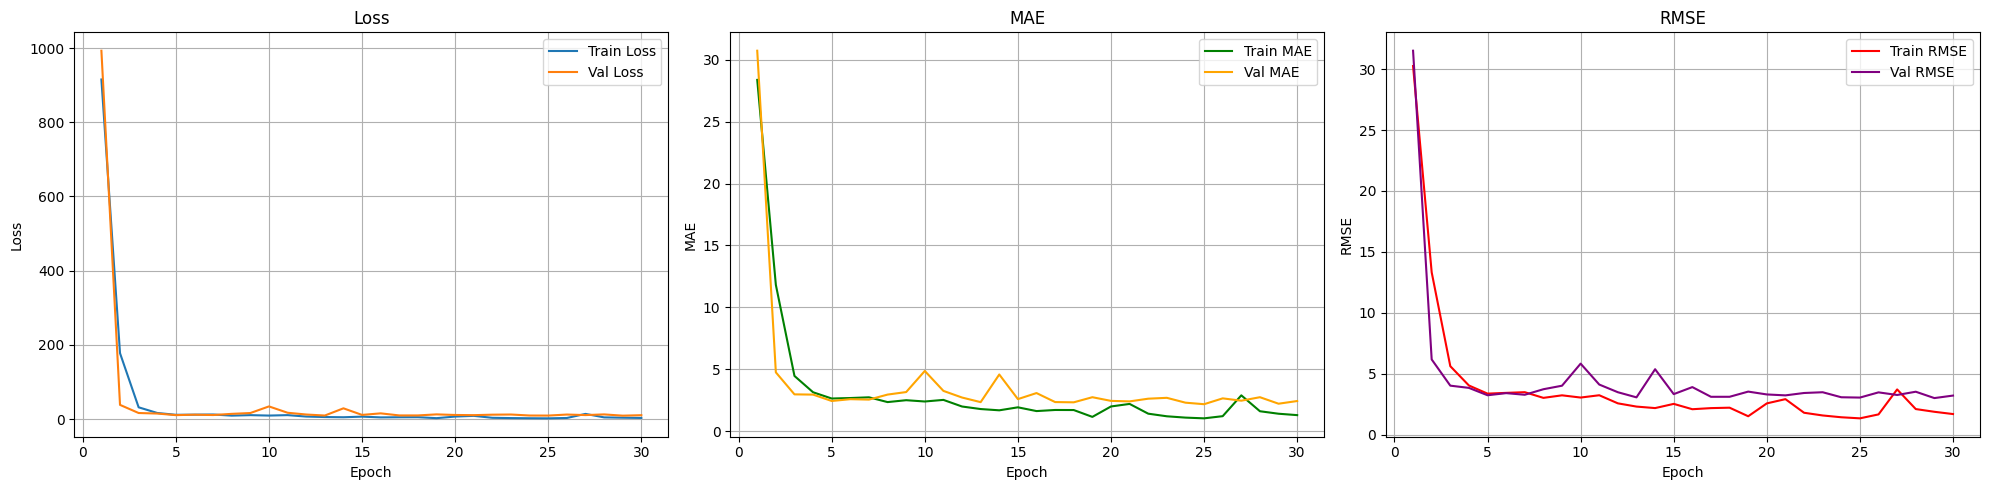

In [21]:
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, train_mae_history, label='Train MAE', color='green')
plt.plot(epochs, val_mae_history, label='Val MAE', color='orange')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, train_rmse_history, label='Train RMSE', color='red')
plt.plot(epochs, val_rmse_history, label='Val RMSE', color='purple')
plt.title('RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
#모델 저장 
torch.save(best_model_wts, 'best_model.pth')

NameError: name 'best_model_wts' is not defined